In [1]:
import numpy as np
import json

In [2]:
def load_data(json_file: str='/content/help.json') -> dict:
  global names, scales
  f = open(json_file)
  data = json.load(f)
  names = data['names']
  names_scaled = data['names_scaled']
  names_unscaled = data['names_unscaled']
  scales = data['scales']
  arrays = {}
  for name in names:
    loaded_arr = np.loadtxt(name)
  
    arrays[name] = loaded_arr.reshape(
        loaded_arr.shape[0], loaded_arr.shape[1] // scales[name][2], scales[name][2])
  f.close()
  return arrays

In [3]:
arr = load_data()

In [4]:
len(arr['(scaled)graphother_22.txt'][1])

24

In [5]:
names

['(scaled)graphother_22.txt',
 '(unscaled)graphother_22.txt',
 '(scaled)graphvalve1_14.txt',
 '(unscaled)graphvalve1_14.txt',
 '(scaled)graphvalve2_3.txt',
 '(unscaled)graphvalve2_3.txt']

In [6]:
cols = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint']

In [7]:
anomalies = []
cps = []
anomaly = []

In [8]:
import copy
result_csp = []
for j in range(len(names)):
  csp = arr[names[j]][0]
  for i in range(1, len(arr[names[j]])):
    csp = np.concatenate((csp, arr[names[j]][i]), axis=0)
  result_csp.append(csp)
anomalies = copy.deepcopy(result_csp)
csp = copy.deepcopy(result_csp)

In [9]:
np.array(anomalies[0][0:,9:10]).shape

(25320, 1)

In [10]:
for i in range(len(result_csp)):
  anomaly.append(anomalies[i][0:,8:9])
  anomaly[i] = np.round_(anomaly[i])
  result_csp[i] = result_csp[i][0:,0:8]
  cps.append(anomalies[i][0:, 9:])
  cps[i] = np.round_(cps[i])
  result_csp[i] = result_csp[i][0:,0:8]

In [11]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import pandas as pd
from itertools import product

In [12]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [13]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [54]:
def arch(data):
    Random(0)
    model = keras.Sequential(
        [
            layers.Input(shape=(data.shape[1], data.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-3), loss="mse")
    # model.compile(optimizer=keras.optimizers.experimental.AdamW(learning_rate=0.001), loss="mse")

    # model.summary()

    history = model.fit(
        data,
        data,
        epochs=100,
        batch_size=128,
        validation_split=0.2,
        verbose=1
        # metrics=[f1]#,
        # callbacks=[
        #     keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        # ],
    )
    return history, model

In [55]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=24):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [56]:
# hyperparameters selection
N_STEPS = 24
Q = 0.85 # quantile for upper control limit (UCL) selection
from tqdm import tqdm
# inference
predicted_outlier, predicted_cp, out = [], [], []
for df in tqdm([result_csp[0]]):
    # X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    X_train = df[:6000]
    # scaler init and fitting
    # StSc = StandardScaler()
    # StSc.fit(X_train)
    # convert into input/output
    # X = create_sequences(StSc.transform(X_train), N_STEPS)
    X = create_sequences(X_train, 24)
    # model defining and fitting
    history, model = arch(X)
    out.append(history.history)  
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    UCL = residuals.quantile(Q)
    
    # results predicting
    # X = create_sequences(X, N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > (3/2 * UCL)
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 0.1933 - val_loss: 0.1278
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1199 - val_loss: 0.1215
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1154 - val_loss: 0.1204
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1143 - val_loss: 0.1194
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1138 - val_loss: 0.1190
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 0.1136 - val_loss: 0.1189
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - loss: 0.1135 - val_loss: 0.1189
Epoch 8/100
16/16 [==============================] - 0s 15ms/step - loss: 0.1134 - val_loss: 0.1188
Epoch 9/100
16/16 [==============================] - 0s 15ms/step - loss: 0.1133 - val_loss: 0.1188
Epoch 10/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1133 - val_loss: 0.1189

 17%|█▋        | 1/6 [00:28<02:24, 28.99s/it]

Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 0.1923 - val_loss: 0.1279
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1196 - val_loss: 0.1206
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1146 - val_loss: 0.1192
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1136 - val_loss: 0.1187
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1133 - val_loss: 0.1186
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 0.1131 - val_loss: 0.1186
Epoch 7/100
16/16 [==============================] - 0s 18ms/step - loss: 0.1130 - val_loss: 0.1186
Epoch 8/100
16/16 [==============================] - 0s 18ms/step - loss: 0.1129 - val_loss: 0.1184
Epoch 9/100
16/16 [==============================] - 0s 19ms/step - loss: 0.1128 - val_loss: 0.1185
Epoch 10/100
16/16 [==============================] - 0s 15ms/step - loss: 0.1127 - val_loss: 0.1184

 33%|███▎      | 2/6 [00:57<01:54, 28.56s/it]

Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 0.1328 - val_loss: 0.0503
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0459 - val_loss: 0.0384
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0417 - val_loss: 0.0377
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0406 - val_loss: 0.0368
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0399 - val_loss: 0.0361
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0393 - val_loss: 0.0358
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0389 - val_loss: 0.0358
Epoch 8/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0387 - val_loss: 0.0356
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0385 - val_loss: 0.0356
Epoch 10/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0384 - val_loss: 0.0355

 50%|█████     | 3/6 [01:40<01:45, 35.06s/it]

Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 0.1329 - val_loss: 0.0500
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0385
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0418 - val_loss: 0.0378
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0408 - val_loss: 0.0370
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0401 - val_loss: 0.0363
Epoch 6/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0394 - val_loss: 0.0359
Epoch 7/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0390 - val_loss: 0.0358
Epoch 8/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0388 - val_loss: 0.0356
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0386 - val_loss: 0.0356
Epoch 10/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0385 - val_loss: 0.0355

 67%|██████▋   | 4/6 [02:08<01:04, 32.40s/it]

Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 0.1300 - val_loss: 0.0498
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0521 - val_loss: 0.0445
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0478 - val_loss: 0.0427
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0467 - val_loss: 0.0420
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0461 - val_loss: 0.0418
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0457 - val_loss: 0.0418
Epoch 7/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0455 - val_loss: 0.0417
Epoch 8/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0452 - val_loss: 0.0417
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0451 - val_loss: 0.0414
Epoch 10/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0449 - val_loss: 0.0413

 83%|████████▎ | 5/6 [02:50<00:36, 36.07s/it]

Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 0.1299 - val_loss: 0.0497
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0520 - val_loss: 0.0444
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0477 - val_loss: 0.0427
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0466 - val_loss: 0.0420
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0461 - val_loss: 0.0418
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0457 - val_loss: 0.0419
Epoch 7/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0454 - val_loss: 0.0418
Epoch 8/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0452 - val_loss: 0.0420
Epoch 9/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0451 - val_loss: 0.0415
Epoch 10/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0449 - val_loss: 0.0413

100%|██████████| 6/6 [03:22<00:00, 33.75s/it]


In [58]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
import os
# from evaluating import evaluating_change_point

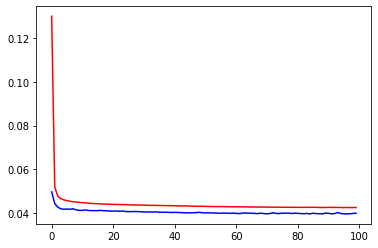

In [59]:
plt.plot(history.history['val_loss'], label='val', color='blue')
plt.plot(history.history['loss'], label='train', color='red')

In [70]:
X

array([[[0.44913313, 0.49150798, 0.47379276, ..., 0.66506067,
         0.519594  , 0.82725935],
        [0.50649492, 0.4596195 , 0.29235379, ..., 0.63836422,
         0.38864503, 0.82170867],
        [0.51431891, 0.48552355, 0.4118939 , ..., 0.65100842,
         0.48268317, 0.82070952],
        ...,
        [0.22396695, 0.38129389, 0.71372444, ..., 0.78121968,
         0.9202579 , 0.82505076],
        [0.28079812, 0.31316492, 0.32335163, ..., 0.76774622,
         0.67485148, 0.82220571],
        [0.28364874, 0.36428168, 0.62421699, ..., 0.77542955,
         0.81018104, 0.82323413]],

       [[0.50649492, 0.4596195 , 0.29235379, ..., 0.63836422,
         0.38864503, 0.82170867],
        [0.51431891, 0.48552355, 0.4118939 , ..., 0.65100842,
         0.48268317, 0.82070952],
        [0.49193137, 0.52060728, 0.39623627, ..., 0.66826495,
         0.57171297, 0.8241006 ],
        ...,
        [0.28079812, 0.31316492, 0.32335163, ..., 0.76774622,
         0.67485148, 0.82220571],
        [0.2

ValueError: ignored

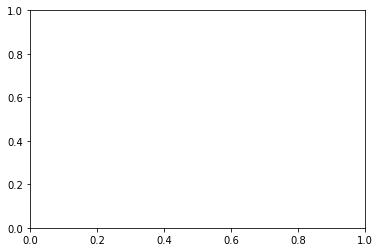

In [75]:
plt.plot(anomaly[4], predicted_outlier[4])

KeyError: ignored

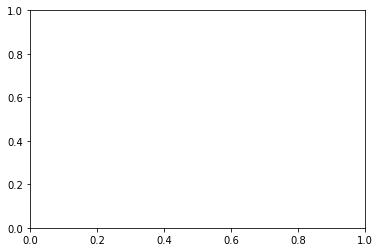

In [60]:
# true outlier indices selection
# true_outlier = [df.anomaly for df in result_csp]
# import matplotlib as plt
true_outlier = anomaly
# pd.DataFrame(predicted_outlier[4]).plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
# pd.DataFrame(true_outlier[4]).plot(marker='o', markersize=2)

plt.plot(pd.DataFrame(true_outlier[4]), pd.DataFrame(true_outlier[4]))
# plt.legend();

In [61]:
pd.DataFrame(true_outlier[0])

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
25315,0.0
25316,0.0
25317,0.0
25318,0.0


In [62]:
true_outlier[1]

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [64]:
# binary classification metrics calculation
binary = evaluating_change_point(pd.DataFrame(true_outlier[0]), pd.DataFrame(predicted_outlier[0]), metric='binary', numenta_time='60 sec')

False Alarm Rate 0    0.0
dtype: float64 %
Missing Alarm Rate 0   NaN
dtype: float64 %
F1 metric 0   NaN
dtype: float64


In [52]:
import pandas as pd
import numpy as np

def evaluating_change_point(true, prediction, metric='nab', numenta_time=None):
    """
    true - both:
                list of pandas Series with binary int labels
                pandas Series with binary int labels
    prediction - both:
                      list of pandas Series with binary int labels
                      pandas Series with binary int labels
    metric: 'nab', 'binary' (FAR, MAR), 'average_delay'
                
    """
    
    def binary(true, prediction):      
        """
        true - true binary series with 1 as anomalies
        prediction - trupredicted binary series with 1 as anomalies
        """
        def single_binary(true,prediction):
            true_ = true == 1 
            prediction_ = prediction == 1
            TP = (true_ & prediction_).sum()
            TN = (~true_ & ~prediction_).sum()
            FP = (~true_ & prediction_).sum()
            FN = (true_ & ~prediction_).sum()
            return TP,TN,FP,FN
            
        if type(true) != type(list()):
            TP,TN,FP,FN = single_binary(true,prediction)
        else:
            TP,TN,FP,FN = 0,0,0,0
            for i in range(len(true)):
                TP_,TN_,FP_,FN_ = single_binary(true[i],prediction[i])
                TP,TN,FP,FN = TP+TP_,TN+TN_,FP+FP_,FN+FN_       
    
        f1 = round(TP/(TP+(FN+FP)/2), 2)
        print(f'False Alarm Rate {round(FP/(FP+TN)*100,2)} %' )
        print(f'Missing Alarm Rate {round(FN/(FN+TP)*100,2)} %')
        print(f'F1 metric {f1}')
        return f1
    
    def average_delay(detecting_boundaries, prediction):
        
        def single_average_delay(detecting_boundaries, prediction):
            missing = 0
            detectHistory = []
            for couple in detecting_boundaries:
                t1 = couple[0]
                t2 = couple[1]
                if prediction[t1:t2].sum()==0:
                    missing+=1
                else:
                    detectHistory.append(prediction[prediction ==1][t1:t2].index[0]-t1)
            return missing, detectHistory
            
        
        if type(prediction) != type(list()):
            missing, detectHistory = single_average_delay(detecting_boundaries, prediction)
        else:
            missing, detectHistory = 0, []
            for i in range(len(prediction)):
                missing_, detectHistory_ = single_average_delay(detecting_boundaries[i], prediction[i])
                missing, detectHistory = missing+missing_, detectHistory+detectHistory_

        add = pd.Series(detectHistory).mean()
        print('Average delay', add)
        print(f'A number of missed CPs = {missing}')
        return add
    
    def evaluate_nab(detecting_boundaries, prediction, table_of_coef=None):
        """
        Scoring labeled time series by means of
        Numenta Anomaly Benchmark methodics
        Parameters
        ----------
        detecting_boundaries: list of list of two float values
            The list of lists of left and right boundary indices
            for scoring results of labeling
        prediction: pd.Series with timestamp indices, in which 1 
            is change point, and 0 in other case. 
        table_of_coef: pandas array (3x4) of float values
            Table of coefficients for NAB score function
            indeces: 'Standart','LowFP','LowFN'
            columns:'A_tp','A_fp','A_tn','A_fn'
        Returns
        -------
        Scores: numpy array, shape of 3, float
            Score for 'Standart','LowFP','LowFN' profile 
        Scores_null: numpy array, shape 3, float
            Null score for 'Standart','LowFP','LowFN' profile             
        Scores_perfect: numpy array, shape 3, float
            Perfect Score for 'Standart','LowFP','LowFN' profile  
        """
        def single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=None, name_of_dataset=None):
            if table_of_coef is None:
                table_of_coef = pd.DataFrame([[1.0,-0.11,1.0,-1.0],
                                     [1.0,-0.22,1.0,-1.0],
                                      [1.0,-0.11,1.0,-2.0]])
                table_of_coef.index = ['Standart','LowFP','LowFN']
                table_of_coef.index.name = "Metric"
                table_of_coef.columns = ['A_tp','A_fp','A_tn','A_fn']

            alist = detecting_boundaries.copy()
            prediction = prediction.copy()

            Scores, Scores_perfect, Scores_null=[], [], []
            for profile in ['Standart', 'LowFP', 'LowFN']:       
                A_tp = table_of_coef['A_tp'][profile]
                A_fp = table_of_coef['A_fp'][profile]
                A_fn = table_of_coef['A_fn'][profile]
                def sigm_scale(y, A_tp, A_fp, window=1):
                    return (A_tp-A_fp)*(1/(1+np.exp(5*y/window))) + A_fp

                #First part
                score = 0
                if len(alist)>0:
                    score += prediction[:alist[0][0]].sum()*A_fp
                else:
                    score += prediction.sum()*A_fp
                #second part
                for i in range(len(alist)):
                    if i<=len(alist)-2:
                        win_space = prediction[alist[i][0]:alist[i+1][0]].copy()
                    else:
                        win_space = prediction[alist[i][0]:].copy()
                    win_fault = prediction[alist[i][0]:alist[i][1]]
                    slow_width = int(len(win_fault)/4)

                    if len(win_fault) + slow_width >= len(win_space):
                        print(f'Intersection of the windows of too wide widths for dataset {name_of_dataset}')
                        win_fault_slow = win_fault.copy()
                    else:
                        win_fault_slow= win_space[:len(win_fault)  +  slow_width]

                    win_fp = win_space[-len(win_fault_slow):]

                    if win_fault_slow.sum() == 0:
                        score+=A_fn
                    else:
                        #to get the first index
                        tr = pd.Series(win_fault_slow.values,index = range(-len(win_fault), len(win_fault_slow)-len(win_fault)))
                        tr_values= tr[tr==1].index[0]
                        tr_score = sigm_scale(tr_values, A_tp,A_fp,slow_width)
                        score += tr_score
                        score += win_fp.sum()*A_fp
                Scores.append(score)
                Scores_perfect.append(len(alist)*A_tp)
                Scores_null.append(len(alist)*A_fn)
            return np.array([np.array(Scores),np.array(Scores_null), np.array(Scores_perfect)])
       #======      
        if type(prediction) != type(list()):
            matrix = single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=table_of_coef)
        else:
            matrix = np.zeros((3,3))
            for i in range(len(prediction)):
                matrix_ = single_evaluate_nab(detecting_boundaries[i], prediction[i], table_of_coef=table_of_coef,name_of_dataset=i)
                matrix = matrix + matrix_      
                
        results = {}
        desc = ['Standart', 'LowFP', 'LowFN'] 
        for t, profile_name in enumerate(desc):
            results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
            print(profile_name,' - ', results[profile_name])
        
        return results
            
            
    #=========================================================================
    if type(true) != type(list()):
        true_items = true[true==1].index
    else:
        true_items = [true[i][true[i]==1].index for i in range(len(true))]
        

    if not metric=='binary':
        def single_detecting_boundaries(true, numenta_time, true_items):
            detecting_boundaries=[]
            td = pd.Timedelta(numenta_time) if numenta_time is not None else pd.Timedelta((true.index[-1]-true.index[0])/len(true_items))  
            for val in true_items:
                detecting_boundaries.append([val, val + td])
            return detecting_boundaries
        
        if type(true) != type(list()):
            detecting_boundaries = single_detecting_boundaries(true=true, numenta_time=numenta_time, true_items=true_items)
        else:
            detecting_boundaries=[]
            for i in range(len(true)):
                detecting_boundaries.append(single_detecting_boundaries(true=true[i], numenta_time=numenta_time, true_items=true_items[i]))

    if metric== 'nab':
        return evaluate_nab(detecting_boundaries, prediction)
    elif metric=='average_delay':
        return average_delay(detecting_boundaries, prediction)
    elif metric== 'binary':
        return binary(true, prediction)